In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

In [ ]:
with open('/content/names.txt',mode='r',encoding='utf-8') as f:
  words=f.read().split()

In [ ]:
vocab=sorted(set(list(''.join(words))))

In [ ]:
# build the vocabulary of characters and mapping to /from integers
stoi ={s:i+1 for i , s in enumerate(vocab)}
stoi['.']=0
# reverse mapping
itos={i:s for  s,i in stoi.items()}

In [ ]:
def build_dataset(words):

  X,Y=[],[]

  block_size=3
  context=[0]*block_size
  for w in words:
    for ch in w + '.':
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)
      context=context[1:] + [ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)
  print(X.shape,Y.shape)

  return X,Y

In [ ]:
block_size=3

In [ ]:
random.seed(42)
random.shuffle(words)

In [ ]:
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1]) #  80%
Xdev,Ydev=build_dataset(words[n1:n2]) #  10%
Xte,yte=build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g)
b1=torch.randn(n_hidden,                          generator=g)
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0
parameters=[C,W1,b1,W2,b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad=True

In [ ]:
lossi=[]
stepsi=[]

In [ ]:
batch_size=32
max_steps=10000

for  i in range(max_steps):

  # minibatch construct
  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) # concatenate the vectors
  hpreact=embcat @ W1+b1 #  hidden layer pre - activation
  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2+b2 # output layer
  loss=F.cross_entropy(logits,Ytr[Yb]) # loss_funtion
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0 if i  < 10000 else 0.01
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000==0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

  break


      0/  10000:3.2931


In [ ]:
@torch.no_grad()
def  split_loss(split):
  x,y={
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,yte),
  }[split]

  emb=C[x]
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])
  hpreact=embcat @ W1 + b1
  h=torch.tanh(hpreact)
  logits=h @ W2+ b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 3.3029866218566895
val 3.3033149242401123


# **1-fixing the saturated tanh**

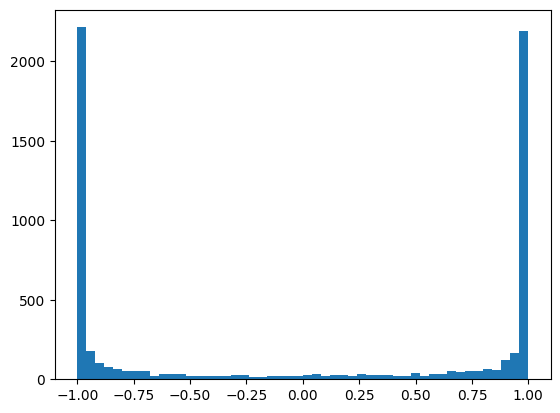

In [ ]:
plt.hist(h.view(-1).tolist(),50);

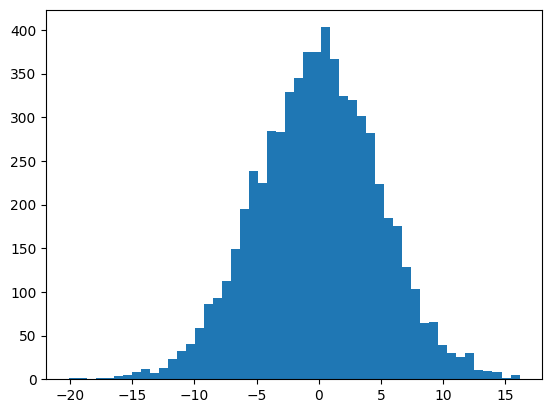

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

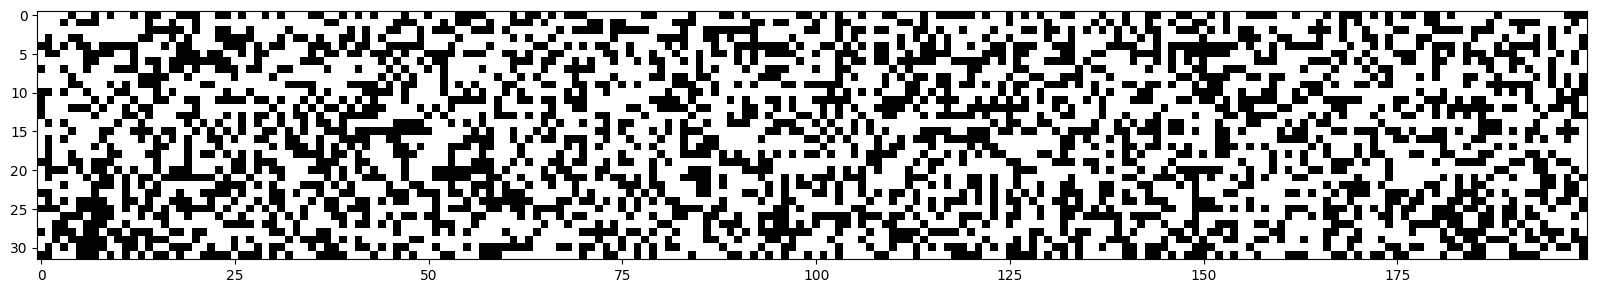

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='gray',interpolation='nearest')

In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g) *0.2
b1=torch.randn(n_hidden,                          generator=g) *0.01
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0
parameters=[C,W1,b1,W2,b2]

In [ ]:
for p in parameters:
  p.requires_grad=True

In [ ]:
batch_size=32
max_steps=10000

for  i in range(max_steps):

  # minibatch construct
  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) # concatenate the vectors
  hpreact=embcat @ W1+b1 #  hidden layer pre - activation
  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2+b2 # output layer
  loss=F.cross_entropy(logits,Ytr[Yb]) # loss_funtion
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0 if i  < 10000 else 0.01
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000==0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  10000:3.2966
   1000/  10000:3.2655
   2000/  10000:3.2882
   3000/  10000:3.2913
   4000/  10000:3.3130
   5000/  10000:3.3048
   6000/  10000:3.3190
   7000/  10000:3.3022
   8000/  10000:3.3076
   9000/  10000:3.2955


In [ ]:
@torch.no_grad()
def  split_loss(split):
  x,y={
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,yte),
  }[split]

  emb=C[x]
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])
  hpreact=embcat @ W1 + b1
  h=torch.tanh(hpreact)
  logits=h @ W2+ b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 3.2979278564453125
val 3.297978162765503


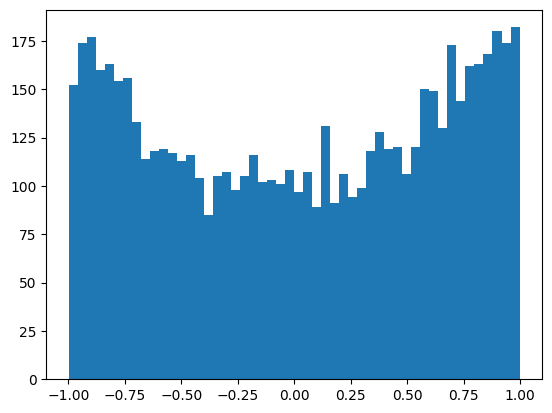

In [ ]:
plt.hist(h.view(-1).tolist(),50);

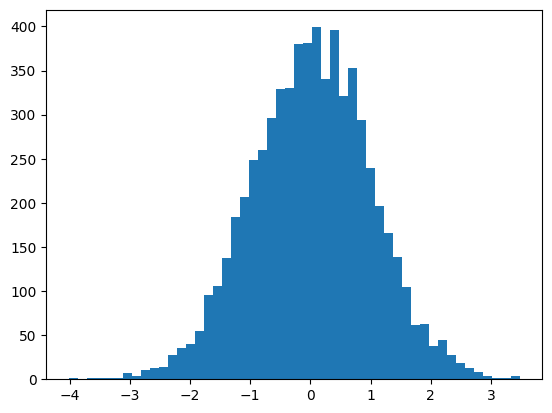

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50);

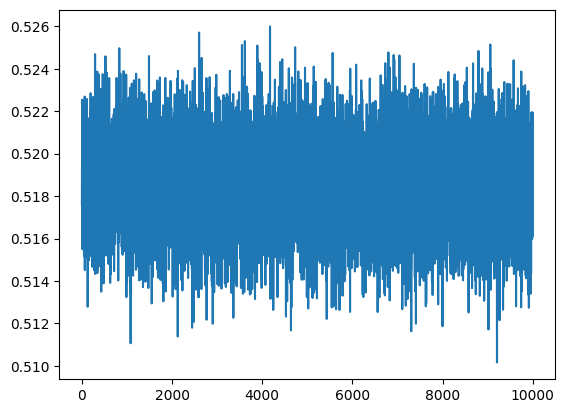

In [ ]:
plt.plot(lossi)

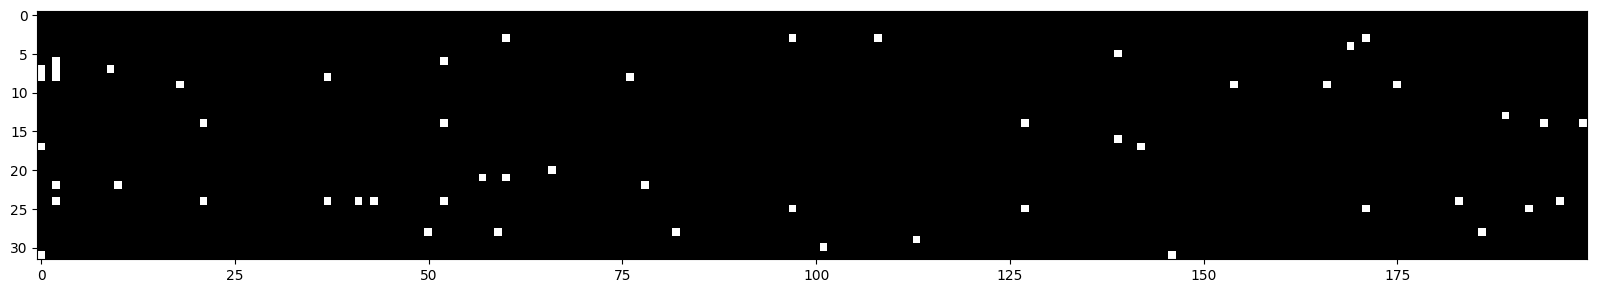

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99,cmap='gray',interpolation='nearest')

# **2-Calculating the init scale: “Kaiming init”**

In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g) *(5/3) / ((n_embed * block_size)**0.5)  #0.2
b1=torch.randn(n_hidden,                          generator=g) *0.01
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0
parameters=[C,W1,b1,W2,b2]

In [ ]:
for p in parameters:
  p.requires_grad=True

In [ ]:
lossi=[]

In [ ]:
batch_size=32
max_steps=10000

for  i in range(max_steps):

  # minibatch construct
  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) # concatenate the vectors
  hpreact=embcat @ W1+b1 #  hidden layer pre - activation
  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2+b2 # output layer
  loss=F.cross_entropy(logits,Ytr[Yb]) # loss_funtion
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0 if i  < 10000 else 0.01
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000==0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  10000:3.2948
   1000/  10000:3.2620
   2000/  10000:3.2879
   3000/  10000:3.2919
   4000/  10000:3.3173
   5000/  10000:3.3061
   6000/  10000:3.3239
   7000/  10000:3.3045
   8000/  10000:3.3104
   9000/  10000:3.2958


In [ ]:
@torch.no_grad()
def  split_loss(split):
  x,y={
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,yte),
  }[split]

  emb=C[x]
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])
  hpreact=embcat @ W1 + b1
  h=torch.tanh(hpreact)
  logits=h @ W2+ b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 3.2994370460510254
val 3.299485206604004


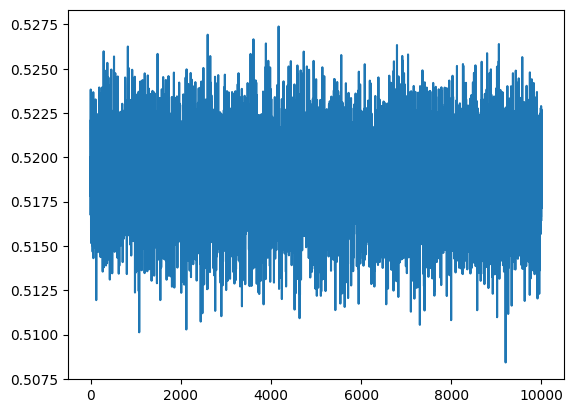

In [ ]:
plt.plot(lossi)

#**3-Batch normalization**

In [ ]:
n_embed=10
n_hidden=200


g=torch.Generator().manual_seed(2134563788) # for reproducibility
C=torch.randn([len(vocab)+1,n_embed],             generator=g)
# Layer 1
W1=torch.randn([n_embed * block_size,n_hidden] ,  generator=g) *(5/3) / ((n_embed * block_size)**0.5)  #0.2
b1=torch.randn(n_hidden,                          generator=g) *0.01
# Layer 2
W2=torch.randn([n_hidden,len(vocab)+1],           generator=g)*0.01
b2=torch.randn(len(vocab)+1,                      generator=g)*0
# BatchNorm parameters
bngain=torch.randn(1,n_hidden                             )*0.1+1.0
bnbias=torch.randn(1,n_hidden                            )*0.1



parameters=[C,W1,b1,W2,b2,bngain,bnbias]
sum(p.nelement() for   p in parameters) # total numbers of parameters
for p  in parameters :
  p.requires_grad=True

In [ ]:
batch_size=32
max_steps=10000

for  i in range(max_steps):

  # minibatch construct
  ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
  Xb,Yb=Xtr[ix],Ytr[ix] # batch X,Y

  # forward pass
  emb=C[Xb] # embed the characters into vectors
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2]) # concatenate the vectors
  hpreact=embcat @ W1+b1 #  hidden layer pre - activation
  # BatchNorm layer
  # ------------------------------------------------------
  bnmeani=hpreact.mean(axis=0,keepdim=True)
  bnstdi=hpreact.std(axis=0,keepdim=True)
  hpreact=bngain*(hpreact-bnmeani) / bnstdi + bnbias

  with torch.no_grad():
    bnmean_running=0.999 * bnmean_running + 0.001*bnmeani
    bnstd_running=0.999 * bnstd_running + 0.001*bnstdi


  h=torch.tanh(hpreact) # hidden layer
  logits=h @ W2+b2 # output layer
  loss=F.cross_entropy(logits,Ytr[Yb]) # loss_funtion
  #print(f'loss:{loss.item()},epochs:{i+1}')

  for  p in parameters:
    p.grad=None

  # backward pass
  loss.backward()

  # update
  lr=0 if i  < 10000 else 0.01
  for p  in parameters:
    p.data+=-lr*p.grad

  # strack stats
  if i % 1000==0:# print every once in while
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  10000:3.3009
   1000/  10000:3.2686
   2000/  10000:3.2939
   3000/  10000:3.2873
   4000/  10000:3.3110
   5000/  10000:3.3164
   6000/  10000:3.3180
   7000/  10000:3.3078
   8000/  10000:3.3183
   9000/  10000:3.2980


In [ ]:
@torch.no_grad()
def  split_loss(split):
  x,y={
      'train':(Xtr,Ytr),
      'val':(Xdev,Ydev),
      'test':(Xte,yte),
  }[split]

  emb=C[x]
  embcat=emb.view(emb.shape[0],emb.shape[1]*emb.shape[2])
  hpreact=embcat @ W1 + b1
  hpreact=bngain*(hpreact-bnmean_running) / bnstd_running + bnbias
  h=torch.tanh(hpreact)
  logits=h @ W2+ b2
  loss=F.cross_entropy(logits,y)
  print(split,loss.item())

split_loss('train')
split_loss('val')

train 3.299492120742798
val 3.2995262145996094
